# mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7

Mounted at /content/drive
/content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7


# Extract weights

## generate para_dict

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
self.label_files: ['/content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7/data/CityCam/test/410/410-20160429-07-000035.txt', '/content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7/data/CityCam/test/410/410-20160429-07-000068.txt', '/content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7/data/CityCam/test/410/410-20160429-07-000094.txt', '/content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7/data/CityCam/test/410/410-20160429-07-000185.txt', '/content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7/data/CityCam/test/410/410-20160429-07-000459.txt', '/content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7/data/CityCam/test/410/410-20160429-07-000469.txt']


test: Scanning '/content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7/data/CityCam/test.cache' images and labels... 6 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 6/6 [00:00<?, ?it/s]


len(dataset): 6


  0%|          | 0/6 [00:00<?, ?it/s]


>>> img.shape: torch.Size([1, 3, 480, 672])
>>> img.shape: torch.Size([1, 3, 240, 336])
>>> img.shape: torch.Size([1, 3, 320, 320])
>>> img.shape: torch.Size([1, 3, 160, 160])
[0] output shape: [32, 160, 160], size (kB): 819.2
[1] output shape: [64, 80, 80], size (kB): 409.6
[2] output shape: [64, 80, 80], size (kB): 409.6
[3] output shape: [128, 40, 40], size (kB): 204.8
[4] output shape: [64, 40, 40], size (kB): 102.4
[5] output shape: [64, 40, 40], size (kB): 102.4
[6] output shape: [64, 40, 40], size (kB): 102.4
[7] output shape: [64, 40, 40], size (kB): 102.4
[8] output shape: [64, 40, 40], size (kB): 102.4
[9] output shape: [64, 40, 40], size (kB): 102.4
[10] output shape: [256, 40, 40], size (kB): 409.6
[11] output shape: [256, 40, 40], size (kB): 409.6
[12] output shape: [256, 20, 20], size (kB): 102.4
[13] output shape: [128, 20, 20], size (kB): 51.2
[14] output shape: [128, 40, 40], size (kB): 204.8
[15] output shape: [128, 20, 20], size (kB): 51.2
[16] output shape: [256, 2

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


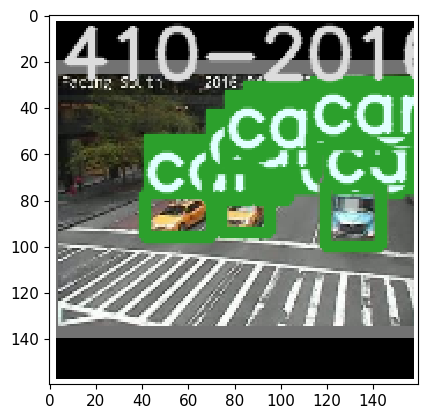

 17%|█▋        | 1/6 [00:04<00:22,  4.50s/it]

Results saved to runs/test/Q1/refine126


In [57]:
# import sys
# sys.path.append('/content/drive/MyDrive/colab_experiment/RBPJ/yolo7-test/yolov7')
%matplotlib inline
from matplotlib import pyplot as plt
import argparse
import json
import os
from pathlib import Path
from threading import Thread

import numpy as np
import torch
import yaml
from tqdm import tqdm
from prettytable import PrettyTable
from PIL import Image
from models.experimental import attempt_load
from utils.datasets import create_dataloader
from utils.general import coco80_to_coco91_class, check_dataset, check_file, check_img_size, check_requirements, \
    box_iou, non_max_suppression, scale_coords, xyxy2xywh, xywh2xyxy, set_logging, increment_path, colorstr
from utils.metrics import ap_per_class, ConfusionMatrix
from utils.plots import plot_images, output_to_target, plot_study_txt
from utils.torch_utils import select_device, time_synchronized, TracedModel

import torch.nn as nn


layer_names = ["models.common.Conv"]


def forward_once(model, x, mod_dict):
    # print(f"model.save: {model.save}")

    # model.save == [3, 4, 5, 7, 11, 13, 16, 17, 18, 20, 24, 24, 26, 29, 30, 31, 33, 37, 37, 39, 42, 43, 44, 46, 51, 53, 55, 56, 57, 58, 59, 60, 63, 65, 67, 68, 69, 70, 71, 72, 75, 75, 77, 80, 81, 82, 83, 84, 85, 88, 88, 90, 93, 94, 95, 96, 97, 98, 101, 102, 103, 104]

    y = []  # outputs
    for m in model.model:



        if m.f != -1:  # if not from previous layer
            x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers

        x = m(x)  # run

        # print(f"[{m.i}] {m.type}, f: {m.f}, output shape: {list(x[0].shape)}")



        p = 1
        for i in x[0].shape:
          p *= i
        print(f"[{m.i}] output shape: {list(x[0].shape)}, size (kB): {p/1000.0}")



        # print(m)
        # fromId = [m.f] if isinstance(m.f, int) else m.f

        # for i in range(len(fromId)):
        #     if(fromId[i] < 0):
        #         fromId[i] += m.i


        mod_dict[m.i] = {"fromId": m.f, "mod_type": m.type, "args": {}, "para": {}}

        if(m.type == "models.common.Conv"):
            mod_dict[m.i]["args"]["Conv2d"] = {}
            mod_dict[m.i]["args"]["Conv2d"]["stride"] = m.conv.stride
            mod_dict[m.i]["args"]["Conv2d"]["padding"] = m.conv.padding
            mod_dict[m.i]["args"]["Conv2d"]["kernel_size"] = m.conv.kernel_size

            mod_dict[m.i]["args"]["Conv2d"]["act_func"] = "SiLU"

        elif(m.type == "models.common.Concat"):
            mod_dict[m.i]["args"]["dim"] = m.d
        elif(m.type == "models.common.MP"):
            mod_dict[m.i]["args"]["kernel_size"] = m.m.kernel_size
            mod_dict[m.i]["args"]["stride"] = m.m.stride
            mod_dict[m.i]["args"]["padding"] = m.m.padding
        elif(m.type == "torch.nn.modules.upsampling.Upsample"):
            mod_dict[m.i]["args"]["scale_factor"] = m.scale_factor
            mod_dict[m.i]["args"]["mode"] = m.mode
        elif(m.type == "models.common.SPPCSPC"):
            mod_dict[m.i]["args"] = {"mp": {}, "Conv2d": {}}
            for i in range(3):
                mod_dict[m.i]["args"]["mp"][i] = {}
                mod_dict[m.i]["args"]["mp"][i]["kernel_size"] = m.m[i].kernel_size
                mod_dict[m.i]["args"]["mp"][i]["stride"] = m.m[i].stride
                mod_dict[m.i]["args"]["mp"][i]["padding"] = m.m[i].padding

            for i in range(1, 8):
                mod_dict[m.i]["args"]["Conv2d"][i] = {}
                mod_dict[m.i]["args"]["Conv2d"][i]['stride'] = getattr(m, f"cv{i}").conv.stride
                mod_dict[m.i]["args"]["Conv2d"][i]['padding'] = getattr(m, f"cv{i}").conv.padding
                mod_dict[m.i]["args"]["Conv2d"][i]["kernel_size"] = getattr(m, f"cv{i}").conv.kernel_size
                mod_dict[m.i]["args"]["Conv2d"][i]['act_func'] = "SiLU"
        elif(m.type == "models.common.RepConv"):
            mod_dict[m.i]["args"]["Conv2d"] = {}
            mod_dict[m.i]["args"]["Conv2d"]["stride"] = m.rbr_reparam.stride
            mod_dict[m.i]["args"]["Conv2d"]["padding"] = m.rbr_reparam.padding
            mod_dict[m.i]["args"]["Conv2d"]["kernel_size"] = m.rbr_reparam.kernel_size
            mod_dict[m.i]["args"]["act_func"] = str(m.act)

        elif(m.type == "models.yolo.Detect"):
            mod_dict[m.i]["args"]["Conv2d"] = {}
            for i in range(3):
                mod_dict[m.i]["args"]["Conv2d"][i] = {}
                mod_dict[m.i]["args"]["Conv2d"][i]["stride"] = m.m[i].stride
                mod_dict[m.i]["args"]["Conv2d"][i]["padding"] = m.m[i].padding
                mod_dict[m.i]["args"]["Conv2d"][i]["kernel_size"] = m.m[i].kernel_size
                mod_dict[m.i]["args"]["Conv2d"][i]['act_func'] = ""

        # print()
        for name, param in m.named_parameters():
            # print(f"    {name}: {param.shape}")
            mod_dict[m.i]["para"][name] = np.array(param).astype(np.float16).astype(np.float32)

        # for m_i in m:
        #     print(f"{m_i}")

        y.append(x if m.i in model.save else None)  # save output



    return x



def test(data,
         weights=None,
         batch_size=32,
         imgsz=640,
         conf_thres=0.001,
         iou_thres=0.6,  # for NMS
         save_json=False,
         single_cls=False,
         augment=False,
         verbose=False,
         model=None,
         dataloader=None,
         save_dir=Path(''),  # for saving images
         save_txt=False,  # for auto-labelling
         save_hybrid=False,  # for hybrid auto-labelling
         save_conf=False,  # save auto-label confidences
         plots=True,
         wandb_logger=None,
         compute_loss=None,
         half_precision=True,
         trace=False,
         is_coco=False,
         show_div_cams=False,
         para_dict={}):


    batch_size = 1
    n_batch = 1

    device = select_device(opt.device, batch_size=batch_size)

    # Directories
    save_dir = Path(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model

    gs = max(int(model.stride.max()), 32)  # grid size (max stride)
    imgsz = check_img_size(imgsz, s=gs)  # check img_size

    # Half
    half = device.type != 'cpu' and half_precision  # half precision only supported on CUDA
    if half:
        model.half()

    # Configure
    model.eval()
    if isinstance(data, str):
        with open(data) as f:
            data = yaml.load(f, Loader=yaml.SafeLoader)
    # check_dataset(data)  # check

    # print(f"model: {model}")

    # Dataloader
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    task = opt.task if opt.task in ('train', 'val', 'test') else 'val'  # path to train/val/test images
    dataloader = create_dataloader(data[task], imgsz, batch_size, gs, opt, pad=0.5, rect=True,
                                    prefix=colorstr(f'{task}: '))[0]

    names = {k: v for k, v in enumerate(model.names if hasattr(model, 'names') else model.module.names)}



    model = torch.ao.quantization.quantize_dynamic(
        model,              # the original model
        {torch.nn.Conv2d},  # a set of layers to dynamically quantize
        dtype=torch.qint8)  # the target dtype for quantized weights



    para_dict["input_img"] = []

    for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(dataloader)):

        if(batch_i >= n_batch): break



        # plt.imshow(img[0].permute(2, 1, 0), interpolation='nearest')
        # plt.show()

        # para_dict["input_img"] = img[0].permute(1, 2, 0).numpy()
        para_dict["input_img"].append(img[0].numpy())




        img = img.to(device, non_blocking=True)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        nb, _, height, width = img.shape  # batch size, channels, height, width





        print(f"\n>>> img.shape: {img.shape}")

        m = nn.modules.upsampling.Upsample(scale_factor=0.5, mode='nearest')
        img = m(img)

        print(f">>> img.shape: {img.shape}")

        p2d = (0, 0, 40, 40)
        img = torch.nn.functional.pad(img, p2d, "constant", 0)
        img = img[..., :-16]
        print(f">>> img.shape: {img.shape}")



        m2 = nn.modules.upsampling.Upsample(scale_factor=0.5, mode='nearest')
        img = m2(img)


        print(f">>> img.shape: {img.shape}")


        with torch.no_grad():

            para_dict["mod_dict"] = {}
            out, _ = forward_once(model, img, para_dict["mod_dict"])



            para_dict['out'] = out.detach().numpy()

            out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=[], multi_label=True)


        # Plot images
        print(f"batch_i: {batch_i}")
        if plots and batch_i < 5:

            f = save_dir / f'test_batch{batch_i}_pred.jpg'

            print(f"paths: {paths}")
            print(f"f: {f}")
            print(f"names: {names}")
            mosaic = plot_images(img, output_to_target(out), paths, f, names)

            plt.imshow(mosaic, interpolation='nearest')
            plt.show()


    s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
    print(f"Results saved to {save_dir}{s}")







class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


opt = AttrDict(weights=['./yolov7.pt'],
          data='data/citycam.yaml',
          batch_size=32,
          img_size=640,
          conf_thres=0.001, iou_thres=0.65,
          task='test',
          device='',
          single_cls=False,
          augment=False,
          verbose=True,
          save_txt=False,
          save_hybrid=False,
          save_conf=False,
          save_json=False,
          project='runs/test/Q1',
          name='refine',
          exist_ok=False,
          no_trace=False,
          show_div_cams=True)


para_dict = {"mod_dict": {}}

test(opt.data,
     opt.weights,
     opt.batch_size,
     opt.img_size,
     opt.conf_thres,
     opt.iou_thres,
     opt.save_json,
     opt.single_cls,
     opt.augment,
     opt.verbose,
     save_txt= opt.save_txt | opt.save_hybrid,
     save_hybrid= opt.save_hybrid,
     save_conf= opt.save_conf,
     trace=not opt.no_trace,
     show_div_cams= opt.show_div_cams,
     para_dict=para_dict
)




In [ ]:
s = 0

for mod_id, mod in para_dict["mod_dict"].items():

    for wei_name, wei in mod['para'].items():

        p = 1
        for i in wei.shape:
            p *= i

        s += p
        print(f"[{mod_id}] {wei_name}: {wei.shape}, n: {p}, s: {s}")

s

## manual forward prop

In [106]:


import torch.nn as nn
import torch
import numpy as np

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def npSiLU(x):
    return x*(1/(1+np.exp(-x)))

def Conv_forward(x, args, para):


    out = torch.nn.functional.conv2d(torch.tensor(x, dtype=torch.float32),
                               weight=torch.tensor(para['conv.weight']),
                               bias=torch.tensor(para['conv.bias']),
                               stride=args['Conv2d']['stride'],
                               padding=args['Conv2d']['padding'])


    if(args['Conv2d']['act_func'] == 'SiLU'):
        return npSiLU(out.detach().numpy())
    else:
        return out.detach().numpy()



    # x = sd.x

    # kernel = para['conv.weight']
    # bias = para['conv.bias']


    # p1, p2 = args['Conv2d']['padding']
    # s1, s2 = args['Conv2d']['stride']
    # k1, k2 = args['Conv2d']['kernel_size']
    # w1 = k1//2
    # w2 = k2//2

    # out = np.zeros((para['conv.weight'].shape[0],
    #                 x.shape[1] - 2 * (w1 - p1),
    #                 x.shape[2] - 2 * ((w2 - p2))))

    # for c2 in range(para['conv.weight'].shape[0]): # output ch
    #
    #     # sweep image pixel
    #     for i in range(w1 - p1, x.shape[1] - w1 + p1, s1):
    #         for j in range(w2 - p2, x.shape[2] - w2 + p2, s2):

    #             # accumulate
    #             acc = 0
    #             for c1 in range(x.shape[0]): # input ch

    #                 for u in range(-w1, w1 + 1, 1): # offset

    #                     ii = i + u
    #                     if(ii > x.shape[1]-1 or ii < 0): continue

    #                     for v in range(-w2, w2 + 1, 1): # offset

    #                         jj = j + v
    #                         if(jj > x.shape[2]-1 or jj < 0): continue


    #                         acc += x[c1, ii, jj] * kernel[c2, c1, u + w1, v + w2]

    #             out[c2, i - (w1 - p1), j - (w2 - p2)] = acc + bias[c2]

def Concat_forward(x, args):
    # x has no batch dim, i.e., shape is not [bs, c, h, w] but [c, h, w].
    # args['dim'] assumes x has batch dim.


    # x_ten = [torch.tensor(i[np.newaxis, ...], dtype=torch.float32) for i in x]
    # return np.squeeze(torch.cat(x_ten, args['dim']).detach().numpy(), axis=0)

    # dim = args['dim'] - 1

    s = list(x[0].shape)
    s[0] = sum([i.shape[0] for i in x])
    out = np.zeros(s)

    dim_offset = 0
    for x_i in x:
      out[dim_offset : dim_offset + x_i.shape[0], ...] = x_i
      dim_offset += x_i.shape[0]

    return out

def MP_forward(x, args):

    # m = nn.MaxPool2d(kernel_size=args["kernel_size"], stride=args["stride"], padding=args["padding"])
    # return np.squeeze(m(torch.tensor(x[np.newaxis, ...], dtype=torch.float32)).detach().numpy(), axis=0)

    p = args['padding']
    s = args['stride']
    k = args['kernel_size']

    out = np.zeros((int(x.shape[0]),
                    int(np.ceil((x.shape[1] - (k - 1) + 2 * p) / s)),
                    int(np.ceil((x.shape[2] - (k - 1) + 2 * p) / s))
                    ))

    # sweep image pixel
    for i in range(-p, x.shape[1] - (k - 1) + p, s):
        for j in range(-p, x.shape[2] - (k - 1) + p, s):



            # print(f"j_max: {x.shape[2] - (k - 1) + p - 1}")

            max = np.ones(x.shape[0]) * (-1000000)
            for u in range(0, k, 1): # offset
                ii = i + u
                if(ii > x.shape[1]-1 or ii < 0): continue
                for v in range(0, k, 1): # offset
                    jj = j + v
                    if(jj > x.shape[2]-1 or jj < 0): continue

                    sel = x[:, ii, jj] > max
                    max[sel] = x[sel, ii, jj]

            out[:, (i + p) // s, (j + p) // s] = max


    return out

def Upsample_forward(x, args, para):

    # x = torch.tensor(x[np.newaxis, ...], dtype=torch.float32)
    # m = nn.modules.upsampling.Upsample(scale_factor=args["scale_factor"], mode=args["mode"] )

    # return np.squeeze(m(x).detach().numpy(), axis=0)

    s = int(args["scale_factor"])
    out = np.zeros((x.shape[0], s * x.shape[1], s * x.shape[2]))

    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            out[:, s * i: s * (i + 1), s * j: s * (j + 1)] = x[:, i, j].reshape((x.shape[0], 1, 1))

    return out

def SPPCSPC_forward(x, args, para):

    x1 = Conv_forward(np.copy(x), {'Conv2d': args['Conv2d'][1]}, {'conv.weight': para[f"cv{1}.conv.weight"], 'conv.bias': para[f"cv{1}.conv.bias"]})
    x1 = Conv_forward(x1, {'Conv2d': args['Conv2d'][3]}, {'conv.weight': para[f"cv{3}.conv.weight"], 'conv.bias': para[f"cv{3}.conv.bias"]})
    x1 = Conv_forward(x1, {'Conv2d': args['Conv2d'][4]}, {'conv.weight': para[f"cv{4}.conv.weight"], 'conv.bias': para[f"cv{4}.conv.bias"]})

    cat_in = [x1]
    cat_in.append(MP_forward(np.copy(x1), args['mp'][0]))
    cat_in.append(MP_forward(np.copy(x1), args['mp'][1]))
    cat_in.append(MP_forward(np.copy(x1), args['mp'][2]))

    # x1 = torch.cat(cat_in, 0).detach().numpy()
    x1 = Concat_forward(cat_in, {'dim': 1})

    x1 = Conv_forward(x1, {'Conv2d': args['Conv2d'][5]}, {'conv.weight': para[f"cv{5}.conv.weight"], 'conv.bias': para[f"cv{5}.conv.bias"]})
    y1 = Conv_forward(x1, {'Conv2d': args['Conv2d'][6]}, {'conv.weight': para[f"cv{6}.conv.weight"], 'conv.bias': para[f"cv{6}.conv.bias"]})
    y2 = Conv_forward(x, {'Conv2d': args['Conv2d'][2]}, {'conv.weight': para[f"cv{2}.conv.weight"], 'conv.bias': para[f"cv{2}.conv.bias"]})

    out = Concat_forward([y1, y2], {'dim': 1}) # cat along channel dim.
    out = Conv_forward(out, {'Conv2d': args['Conv2d'][7]}, {'conv.weight': para[f"cv{7}.conv.weight"], 'conv.bias': para[f"cv{7}.conv.bias"]})
    return out

def RepConv_forward(x, args, para):


    # args: {'Conv2d': {'stride': (1, 1), 'padding': (1, 1), 'kernel_size': (3, 3)}, 'act_func': 'SiLU(inplace=True)'}
    #     rbr_reparam.weight: (256, 128, 3, 3)
    #     rbr_reparam.bias: (256,)

    n_ch_out = para['rbr_reparam.weight'].shape[0]
    n_ch_in = para['rbr_reparam.weight'].shape[1]

    m = nn.Conv2d(n_ch_in,
                  n_ch_out,
                  kernel_size=args['Conv2d']['kernel_size'],
                  stride=args['Conv2d']['stride'],
                  padding=args['Conv2d']['padding'])
    act = nn.SiLU(inplace=True)

    m.weight = torch.nn.Parameter(torch.tensor(para['rbr_reparam.weight']))
    m.bias = torch.nn.Parameter(torch.tensor(para['rbr_reparam.bias']))

    out = m(torch.tensor(x[np.newaxis, ...], dtype=torch.float32))

    return np.squeeze(npSiLU(out.detach().numpy()), axis=0)

def Detect_forward(x, args, para):

    def sigmoid(x):
      return 1/(1 + np.exp(-x))

    def make_grid(nx=20, ny=20):

        yv, xv = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')
        return np.concatenate((xv[..., np.newaxis], yv[..., np.newaxis]), axis=2).reshape((1, ny, nx, 2)).astype(np.float32)

    z = []
    stride = np.array([ 8., 16., 32.])
    anchor_grid = np.array([
                                [[[[ 12.,  16.]]],
                                  [[[ 19.,  36.]]],
                                  [[[ 40.,  28.]]]],

                                [[[[ 36.,  75.]]],
                                  [[[ 76.,  55.]]],
                                  [[[ 72., 146.]]]],

                                [[[[142., 110.]]],
                                  [[[192., 243.]]],
                                  [[[459., 401.]]]]
                            ]
                           )

    nl = 3
    no = 85
    na = 3

    m = nn.ModuleList(nn.Conv2d(i, no * na, 1) for i in [256, 512, 1024])

    for i in range(3):
        m[i].weight = torch.nn.Parameter(torch.tensor(para[f"m.{i}.weight"]))
        m[i].bias = torch.nn.Parameter(torch.tensor(para[f"m.{i}.bias"]))


    grid = [np.zeros(1)] * nl



    for i in range(nl):

        x[i] = m[i](torch.tensor(x[i], dtype=torch.float32)).detach().numpy()

        _, ny, nx = x[i].shape


        x[i] = x[i].reshape(3, 85, ny, nx)
        x[i] = np.transpose(x[i], (0, 2, 3, 1))

        # shape: (1, ny, nx, 2)
        grid[i] = make_grid(nx, ny)

        # (3, ny, nx, 85)
        y = sigmoid(x[i])


        y[..., 0:2] = (y[..., 0:2] * 2. - 0.5 + grid[i]) * stride[i]  # xy

        #  anchor_grid: (3, 1, 1, 2)
        y[..., 2:4] = (y[..., 2:4] * 2) ** 2 * anchor_grid[i]  # wh

        z.append(y.reshape(1, -1, 85))

    return np.concatenate(z, axis=1)






def prepare_mod_input(sd, fromId):
    if fromId != -1:  # if not from previous layer
        sd.x = np.copy(sd.y[fromId]) if isinstance(fromId, int) else [np.copy(sd.x) if j == -1 else np.copy(sd.y[j]) for j in fromId]

save = [3, 4, 5, 7, 11, 13, 16, 17, 18, 20, 24, 24, 26, 29, 30, 31, 33, 37, 37, 39, 42, 43, 44, 46, 51, 53, 55, 56, 57, 58, 59, 60, 63, 65, 67, 68, 69, 70, 71, 72, 75, 75, 77, 80, 81, 82, 83, 84, 85, 88, 88, 90, 93, 94, 95, 96, 97, 98, 101, 102, 103, 104]

sd = AttrDict(y = [], x = 0, out=[])

for i, img in enumerate(para_dict["input_img"]):
    print(f"i: {i}")
    # if(i > 0): break

    img = img.astype(np.float32) / 255.0

    img = img[:,::2, ::2]

    pad = np.zeros((img.shape[0], 80, img.shape[2]))
    img = np.concatenate((img, pad), axis=1)
    img = img[..., :-16]

    img = img[:,::2, ::2]
    print(f">>> img.shape: {img.shape}")

    sd.x = img
    # para_dict['input_img'][i] = img



    sd.y = []


    for mod_id, mod in para_dict["mod_dict"].items():

        prepare_mod_input(sd, mod['fromId'])

        if(mod['mod_type'] == "models.common.Conv"):
            sd.x = Conv_forward(np.copy(sd.x), mod['args'], mod['para'])

        elif(mod['mod_type'] == "models.common.Concat"):
            sd.x = Concat_forward(np.copy(sd.x), mod['args'])

        elif(mod['mod_type'] == "models.common.MP"):
            sd.x = MP_forward(np.copy(sd.x), mod['args'])

        elif(mod['mod_type'] == "torch.nn.modules.upsampling.Upsample"):
            sd.x = Upsample_forward(np.copy(sd.x), mod['args'], mod['para'])

        elif(mod['mod_type'] == "models.common.SPPCSPC"):
            sd.x = SPPCSPC_forward(np.copy(sd.x), mod['args'], mod['para'])

        elif(mod['mod_type'] == "models.common.RepConv"):
            sd.x = RepConv_forward(np.copy(sd.x), mod['args'], mod['para'])

        elif(mod['mod_type'] == "models.yolo.Detect"):
            sd.x = Detect_forward(np.copy(sd.x), mod['args'], mod['para'])
            sd.out.append(np.copy(sd.x))

        sd.y.append(np.copy(sd.x) if mod_id in save else None)  # save output


i: 0
>>> img.shape: (3, 160, 160)


<ipython-input-106-ac042a2ec8ca>:11: RuntimeWarning: overflow encountered in exp
  return x*(1/(1+np.exp(-x)))


## manual forward pass - qtz

In [175]:


import torch.nn as nn
import torch
import numpy as np


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def npSiLU(x):
    return x*(1/(1+np.exp(-x)))



def qtz(x, p = 4): # on weights & fm.
    return (x * (2 ** p)).astype(np.int32)


def round_deqtz(x, p = 4): # only on fm.
    x = np.right_shift(x, p)
    # x = np.bitwise_and(x, 0x000000ff).astype(np.int8).astype(np.int32)
    x = x * 1.0
    x = x / (2 ** p)
    return x


def Conv_forward(x, args, para):


    # out = torch.nn.functional.conv2d(torch.tensor(x, dtype=torch.float32),
    #                            weight=torch.tensor(para['conv.weight']),
    #                            bias=torch.tensor(para['conv.bias']),
    #                            stride=args['Conv2d']['stride'],
    #                            padding=args['Conv2d']['padding'])


    # if(args['Conv2d']['act_func'] == 'SiLU'):
    #     return npSiLU(out.detach().numpy())
    # else:
    #     return out.detach().numpy()



    out = torch.nn.functional.conv2d(input = torch.tensor(qtz(x), dtype=torch.int32),
                               weight = torch.tensor(qtz(para['conv.weight']), dtype=torch.int32),
                               bias = torch.tensor(qtz(para['conv.bias']) * (2 ** 4), dtype=torch.int32),
                               stride = args['Conv2d']['stride'],
                               padding = args['Conv2d']['padding'])


    out = round_deqtz(out.detach().numpy()).astype(np.float32)


    if(args['Conv2d']['act_func'] == 'SiLU'):
        return npSiLU(out)
    else:
        return out



def Concat_forward(x, args):
    # x has no batch dim, i.e., shape is not [bs, c, h, w] but [c, h, w].
    # args['dim'] assumes x has batch dim.


    # x_ten = [torch.tensor(i[np.newaxis, ...], dtype=torch.float32) for i in x]
    # return np.squeeze(torch.cat(x_ten, args['dim']).detach().numpy(), axis=0)

    # dim = args['dim'] - 1

    s = list(x[0].shape)
    s[0] = sum([i.shape[0] for i in x])
    out = np.zeros(s)

    dim_offset = 0
    for x_i in x:
      out[dim_offset : dim_offset + x_i.shape[0], ...] = x_i
      dim_offset += x_i.shape[0]

    return out

def MP_forward(x, args):

    # m = nn.MaxPool2d(kernel_size=args["kernel_size"], stride=args["stride"], padding=args["padding"])
    # return np.squeeze(m(torch.tensor(x[np.newaxis, ...], dtype=torch.float32)).detach().numpy(), axis=0)

    p = args['padding']
    s = args['stride']
    k = args['kernel_size']

    out = np.zeros((int(x.shape[0]),
                    int(np.ceil((x.shape[1] - (k - 1) + 2 * p) / s)),
                    int(np.ceil((x.shape[2] - (k - 1) + 2 * p) / s))
                    ))

    # sweep image pixel
    for i in range(-p, x.shape[1] - (k - 1) + p, s):
        for j in range(-p, x.shape[2] - (k - 1) + p, s):



            # print(f"j_max: {x.shape[2] - (k - 1) + p - 1}")

            max = np.ones(x.shape[0]) * (-1000000)
            for u in range(0, k, 1): # offset
                ii = i + u
                if(ii > x.shape[1]-1 or ii < 0): continue
                for v in range(0, k, 1): # offset
                    jj = j + v
                    if(jj > x.shape[2]-1 or jj < 0): continue

                    sel = x[:, ii, jj] > max
                    max[sel] = x[sel, ii, jj]

            out[:, (i + p) // s, (j + p) // s] = max


    return out

def Upsample_forward(x, args, para):

    # x = torch.tensor(x[np.newaxis, ...], dtype=torch.float32)
    # m = nn.modules.upsampling.Upsample(scale_factor=args["scale_factor"], mode=args["mode"] )

    # return np.squeeze(m(x).detach().numpy(), axis=0)

    s = int(args["scale_factor"])
    out = np.zeros((x.shape[0], s * x.shape[1], s * x.shape[2]))

    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            out[:, s * i: s * (i + 1), s * j: s * (j + 1)] = x[:, i, j].reshape((x.shape[0], 1, 1))

    return out

def SPPCSPC_forward(x, args, para):

    x1 = Conv_forward(np.copy(x), {'Conv2d': args['Conv2d'][1]}, {'conv.weight': para[f"cv{1}.conv.weight"], 'conv.bias': para[f"cv{1}.conv.bias"]})
    x1 = Conv_forward(x1, {'Conv2d': args['Conv2d'][3]}, {'conv.weight': para[f"cv{3}.conv.weight"], 'conv.bias': para[f"cv{3}.conv.bias"]})
    x1 = Conv_forward(x1, {'Conv2d': args['Conv2d'][4]}, {'conv.weight': para[f"cv{4}.conv.weight"], 'conv.bias': para[f"cv{4}.conv.bias"]})

    cat_in = [x1]
    cat_in.append(MP_forward(np.copy(x1), args['mp'][0]))
    cat_in.append(MP_forward(np.copy(x1), args['mp'][1]))
    cat_in.append(MP_forward(np.copy(x1), args['mp'][2]))

    # x1 = torch.cat(cat_in, 0).detach().numpy()
    x1 = Concat_forward(cat_in, {'dim': 1})

    x1 = Conv_forward(x1, {'Conv2d': args['Conv2d'][5]}, {'conv.weight': para[f"cv{5}.conv.weight"], 'conv.bias': para[f"cv{5}.conv.bias"]})
    y1 = Conv_forward(x1, {'Conv2d': args['Conv2d'][6]}, {'conv.weight': para[f"cv{6}.conv.weight"], 'conv.bias': para[f"cv{6}.conv.bias"]})
    y2 = Conv_forward(x, {'Conv2d': args['Conv2d'][2]}, {'conv.weight': para[f"cv{2}.conv.weight"], 'conv.bias': para[f"cv{2}.conv.bias"]})

    out = Concat_forward([y1, y2], {'dim': 1}) # cat along channel dim.
    out = Conv_forward(out, {'Conv2d': args['Conv2d'][7]}, {'conv.weight': para[f"cv{7}.conv.weight"], 'conv.bias': para[f"cv{7}.conv.bias"]})
    return out

def RepConv_forward(x, args, para):


    # args: {'Conv2d': {'stride': (1, 1), 'padding': (1, 1), 'kernel_size': (3, 3)}, 'act_func': 'SiLU(inplace=True)'}
    #     rbr_reparam.weight: (256, 128, 3, 3)
    #     rbr_reparam.bias: (256,)

    n_ch_out = para['rbr_reparam.weight'].shape[0]
    n_ch_in = para['rbr_reparam.weight'].shape[1]

    m = nn.Conv2d(n_ch_in,
                  n_ch_out,
                  kernel_size=args['Conv2d']['kernel_size'],
                  stride=args['Conv2d']['stride'],
                  padding=args['Conv2d']['padding'])
    act = nn.SiLU(inplace=True)

    m.weight = torch.nn.Parameter(torch.tensor(para['rbr_reparam.weight']))
    m.bias = torch.nn.Parameter(torch.tensor(para['rbr_reparam.bias']))

    out = m(torch.tensor(x[np.newaxis, ...], dtype=torch.float32))
    return np.squeeze(act(out).detach().numpy(), axis=0)

def Detect_forward(x, args, para):

    def sigmoid(x):
      return 1/(1 + np.exp(-x))

    def make_grid(nx=20, ny=20):

        yv, xv = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')
        return np.concatenate((xv[..., np.newaxis], yv[..., np.newaxis]), axis=2).reshape((1, ny, nx, 2)).astype(np.float32)

    z = []
    stride = np.array([ 8., 16., 32.])
    anchor_grid = np.array([
                                [[[[ 12.,  16.]]],
                                  [[[ 19.,  36.]]],
                                  [[[ 40.,  28.]]]],

                                [[[[ 36.,  75.]]],
                                  [[[ 76.,  55.]]],
                                  [[[ 72., 146.]]]],

                                [[[[142., 110.]]],
                                  [[[192., 243.]]],
                                  [[[459., 401.]]]]
                            ]
                           )

    nl = 3
    no = 85
    na = 3

    m = nn.ModuleList(nn.Conv2d(i, no * na, 1) for i in [256, 512, 1024])

    for i in range(3):
        m[i].weight = torch.nn.Parameter(torch.tensor(para[f"m.{i}.weight"]))
        m[i].bias = torch.nn.Parameter(torch.tensor(para[f"m.{i}.bias"]))


    grid = [np.zeros(1)] * nl



    for i in range(nl):

        x[i] = m[i](torch.tensor(x[i], dtype=torch.float32)).detach().numpy()

        _, ny, nx = x[i].shape


        x[i] = x[i].reshape(3, 85, ny, nx)
        x[i] = np.transpose(x[i], (0, 2, 3, 1))

        # shape: (1, ny, nx, 2)
        grid[i] = make_grid(nx, ny)

        # (3, ny, nx, 85)
        y = sigmoid(x[i])


        y[..., 0:2] = (y[..., 0:2] * 2. - 0.5 + grid[i]) * stride[i]  # xy

        #  anchor_grid: (3, 1, 1, 2)
        y[..., 2:4] = (y[..., 2:4] * 2) ** 2 * anchor_grid[i]  # wh

        z.append(y.reshape(1, -1, 85))

    return np.concatenate(z, axis=1)






def prepare_mod_input(sd, fromId):
    if fromId != -1:  # if not from previous layer
        sd.x = np.copy(sd.y[fromId]) if isinstance(fromId, int) else [np.copy(sd.x) if j == -1 else np.copy(sd.y[j]) for j in fromId]

save = [3, 4, 5, 7, 11, 13, 16, 17, 18, 20, 24, 24, 26, 29, 30, 31, 33, 37, 37, 39, 42, 43, 44, 46, 51, 53, 55, 56, 57, 58, 59, 60, 63, 65, 67, 68, 69, 70, 71, 72, 75, 75, 77, 80, 81, 82, 83, 84, 85, 88, 88, 90, 93, 94, 95, 96, 97, 98, 101, 102, 103, 104]

sd = AttrDict(y = [], x = 0, out=[])

for i, img in enumerate(para_dict["input_img"]):
    print(f"i: {i}")
    # if(i > 0): break

    img = img.astype(np.float32) / 255.0

    img = img[:,::2, ::2]

    pad = np.zeros((img.shape[0], 80, img.shape[2]))
    img = np.concatenate((img, pad), axis=1)
    img = img[..., :-16]

    img = img[:,::2, ::2]
    print(f">>> img.shape: {img.shape}")

    sd.x = img
    # para_dict['input_img'][i] = img



    sd.y = []


    for mod_id, mod in para_dict["mod_dict"].items():

        prepare_mod_input(sd, mod['fromId'])

        if(mod['mod_type'] == "models.common.Conv"):
            sd.x = Conv_forward(np.copy(sd.x), mod['args'], mod['para'])

        elif(mod['mod_type'] == "models.common.Concat"):
            sd.x = Concat_forward(np.copy(sd.x), mod['args'])

        elif(mod['mod_type'] == "models.common.MP"):
            sd.x = MP_forward(np.copy(sd.x), mod['args'])

        elif(mod['mod_type'] == "torch.nn.modules.upsampling.Upsample"):
            sd.x = Upsample_forward(np.copy(sd.x), mod['args'], mod['para'])

        elif(mod['mod_type'] == "models.common.SPPCSPC"):
            sd.x = SPPCSPC_forward(np.copy(sd.x), mod['args'], mod['para'])

        elif(mod['mod_type'] == "models.common.RepConv"):
            sd.x = RepConv_forward(np.copy(sd.x), mod['args'], mod['para'])

        elif(mod['mod_type'] == "models.yolo.Detect"):
            sd.x = Detect_forward(np.copy(sd.x), mod['args'], mod['para'])
            sd.out.append(np.copy(sd.x))

        sd.y.append(np.copy(sd.x) if mod_id in save else None)  # save output


i: 0
>>> img.shape: (3, 160, 160)


<ipython-input-175-59b91c7c978d>:13: RuntimeWarning: overflow encountered in exp
  return x*(1/(1+np.exp(-x)))


## plot results

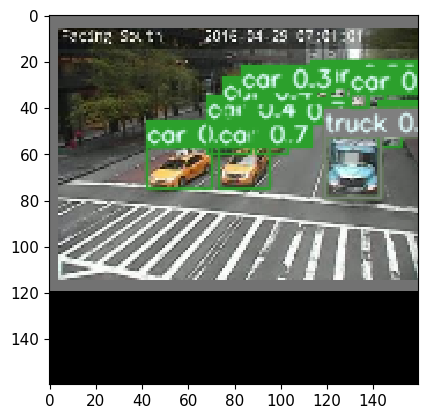

In [176]:

import matplotlib
import math
import cv2
from utils.general import xywh2xyxy, xyxy2xywh
from utils.plots import plot_one_box

def color_list():
    def hex2rgb(h):
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

    return [hex2rgb(h) for h in matplotlib.colors.TABLEAU_COLORS.values()]  # or BASE_ (8), CSS4_ (148), XKCD_ (949)


def plot_images(img, targets, names=None, max_size=640, max_subplots=16, tl = 1):

    names =  {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    if np.max(img) <= 1:
        img *= 255

    _, h, w = img.shape  #


    # Check if we should resize
    scale_factor = max_size / np.max([h, w])

    if scale_factor < 1:
        h = math.ceil(scale_factor * h)
        w = math.ceil(scale_factor * w)

    colors = color_list()  # list of colors
    mosaic = np.full((int(h), int(w), 3), 255, dtype=np.uint8)  # init


    img = img.transpose(1, 2, 0)
    if scale_factor < 1:
        img = cv2.resize(img, (w, h))

    mosaic[:h, :w, :] = img

    if len(targets) > 0:

        image_targets = targets[targets[:, 0] == 0]

        boxes = xywh2xyxy(image_targets[:, 2:6]).T
        classes = image_targets[:, 1].astype('int')
        labels = image_targets.shape[1] == 6  # labels if no conf column
        conf = None if labels else image_targets[:, 6]  # check for confidence presence (label vs pred)

        if boxes.shape[1]:

            if boxes.max() <= 1.01:  # if normalized with tolerance 0.01
                boxes[[0, 2]] *= w  # scale to pixels
                boxes[[1, 3]] *= h

            elif scale_factor < 1:  # absolute coords need scale if image scales
                boxes *= scale_factor

        for j, box in enumerate(boxes.T):

            cls = int(classes[j])
            color = colors[cls % len(colors)]
            cls = names[cls]

            if labels or conf[j] > 0.25:  # 0.25 conf thresh
                label = '%s' % cls if labels else '%s %.1f' % (cls, conf[j])
                plot_one_box(box, mosaic, label=label, color=color, line_thickness=tl)



    r = min(1280. / np.max([h, w]), 1.0)  # ratio to limit image size
    mosaic = cv2.resize(mosaic, (int(w * r), int(h * r)), interpolation=cv2.INTER_AREA)


    return mosaic



def box_area(boxes):
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def box_iou(box1, box2):


    area1 = box_area(box1)  # N
    area2 = box_area(box2)  # M


    lt = np.maximum(box1[:, np.newaxis, :2], box2[:, :2])
    rb = np.minimum(box1[:, np.newaxis, 2:], box2[:, 2:])
    wh = rb - lt
    wh = np.maximum(0, wh) # [N, M, 2]
    inter = wh[:, :, 0] * wh[:, :, 1]
    iou = inter / (area1[:, np.newaxis] + area2 - inter)
    return iou  # NxM



def numpy_nms(boxes, scores, iou_threshold):

    idxs = scores.argsort()
    keep = []
    while idxs.size > 0:
        max_score_index = idxs[-1]
        max_score_box = boxes[max_score_index][None, :]
        keep.append(max_score_index)

        if idxs.size == 1:
            break
        idxs = idxs[:-1]
        other_boxes = boxes[idxs]  # [?, 4]
        # print(f"max_score_box.shape: {max_score_box.shape}, other_boxes.shape: {other_boxes.shape}")
        ious = box_iou(max_score_box, other_boxes)
        idxs = idxs[ious[0] <= iou_threshold]

    keep = np.array(keep)
    return keep




def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=()):

    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Settings
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
    max_det = 300  # maximum number of detections per image
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    output = [np.zeros((0, 6))] * prediction.shape[0]

    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence


        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        if nc == 1:
            x[:, 5:] = x[:, 4:5]

        else:
            x[:, 5:] *= x[:, 4:5]

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        i, j = (x[:, 5:] > conf_thres).nonzero()

        # x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        x = np.concatenate((box[i], x[i, j + 5, None], j[:, None].astype(np.float32)), axis=1)


        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort()[-max_nms:]][::-1]  # sort by confidence

        # Batched NMS
        c = x[:, 5:6] *  max_wh  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores

        # i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = numpy_nms(boxes, scores, iou_thres)

        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]

        output[xi] = x[i]

    return output



def output_to_target(output):

    targets = []
    for i, o in enumerate(output):
        for *box, conf, cls in o:
            targets.append([i, cls, *list(*xyxy2xywh(np.array(box)[None])), conf])
    return np.array(targets)



# out = torch.tensor(sd.x, dtype=torch.float32)

for i in range(len(sd.out)):

    out = non_max_suppression(sd.out[i], conf_thres=0.001, iou_thres=0.6, labels=[], multi_label=True)

    img = para_dict['input_img'][i]
    img = img.astype(np.float32) / 255.0

    img = img[:,::2, ::2]

    pad = np.zeros((img.shape[0], 80, img.shape[2]))
    img = np.concatenate((img, pad), axis=1)
    img = img[..., :-16]
    img = img[:,::2, ::2]


    mosaic = plot_images(img, output_to_target(out))

    plt.imshow(mosaic, interpolation='nearest')
    plt.show()


# Tests

In [37]:

import numpy as np
import torch

from utils.torch_utils import select_device, time_synchronized, TracedModel

import torch.nn as nn



model_fp32 = attempt_load(['./yolov7.pt'], map_location=select_device('', batch_size=1))  # load FP32 model
model_fp32.eval()




for m in model_fp32.model:

    for name, param in m.named_parameters():

        print(f"name: {name}", param[:5,0,0,0])

        break

    break

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
name: conv.weight tensor([-0.19799, -0.42058, -0.53770,  1.03452,  1.41203], grad_fn=<SelectBackward0>)


## test quantization

In [70]:
def qtz(x, p = 8): # on weights & fm.
    return (x * (2 ** p)).astype(np.int32)

def deqtz(x, p = 8):
    return (x * 1.0)/(2 ** p)

def round_deqtz(x, p = 8): # only on fm.
    x = x / (2 ** p)
    x = x.astype(np.int8)
    return (x * 1.0)/(2 ** p)

In [65]:
a = -np.random.rand(6)
b = np.random.rand(6)

In [66]:
a * b

array([   -0.25431,    -0.18817,   -0.068663,    -0.76722,    -0.10004,    -0.65606])

In [69]:

round_deqtz(qtz(a) * qtz(b))

array([      -0.25,    -0.18359,   -0.066406,     0.23828,    -0.09375,     0.34766])

## test conv2d qtz

In [ ]:

def npSiLU(x):
    return x*(1/(1+np.exp(-x)))


args = para_dict["mod_dict"][0]['args']
para = para_dict["mod_dict"][0]['para']
x = np.random.rand(3, 10, 10)

In [173]:

out = torch.nn.functional.conv2d(torch.tensor(x, dtype=torch.float32),
                            weight=torch.tensor(para['conv.weight']),
                            bias=torch.tensor(para['conv.bias']),
                            stride=args['Conv2d']['stride'],
                            padding=args['Conv2d']['padding'])

# print(out[:20,0,0])

# out.detach().numpy()[:5,0,0]
npSiLU(out.detach().numpy())[:5,0,0]


array([  -0.007574,       1.908, -9.0082e-05,     0.93922,      3.7207], dtype=float32)

In [183]:

def qtz(x, p = 11): # on weights & fm.
    return (x * (2 ** p)).astype(np.int32)

# input type: np.int32
def round_deqtz(x, p = 11): # only on fm.
    x = np.right_shift(x, p)
    print(x[:5,0,0])
    x = np.bitwise_and(x, 0x0000ffff).astype(np.int16).astype(np.int32)
    print(x[:5,0,0])
    x = x * 1.0
    x = x / (2 ** p)
    return x

out = torch.nn.functional.conv2d(input = torch.tensor(qtz(x), dtype=torch.int32),
                            weight = torch.tensor(qtz(para['conv.weight']), dtype=torch.int32),
                            bias = torch.tensor(qtz(para['conv.bias']) * (2 ** 11), dtype=torch.int32),
                            stride = args['Conv2d']['stride'],
                            padding = args['Conv2d']['padding'])


out = round_deqtz(out.detach().numpy()).astype(np.float32)
# out[:5,0,0]

npSiLU(out)[:5,0,0]

[-13933   4372 -24136   2493   7786]
[-13933   4372 -24136   2493   7786]


array([ -0.0075445,       1.909, -8.9764e-05,     0.93924,      3.7187], dtype=float32)

## model quantization test

In [ ]:
import torch

# define a floating point model where some layers could be statically quantized
class M(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.ao.quantization.QuantStub()

        self.conv = torch.nn.Conv2d(1, 3, 3)
        self.relu = torch.nn.ReLU()

        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):

        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)

        x = self.conv(x)
        x = self.relu(x)

        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)

        return x

# create a model instance
model_fp32 = M()



model_fp32.eval()


model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('x86')


# model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [['conv', 'relu']])

model_fp32_prepared = torch.ao.quantization.prepare(model_fp32)

input_fp32 = torch.randn(4, 1, 4, 4)
model_fp32_prepared(input_fp32)

model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

# run the model, relevant calculations will happen in int8
res = model_int8(input_fp32)

In [ ]:
for n, para in model_fp32_prepared.conv.named_parameters():
    print(para)

Parameter containing:
tensor([[[[-0.25195,  0.03055,  0.08820],
          [ 0.09190, -0.22733, -0.08123],
          [-0.21385, -0.22114, -0.25910]]],


        [[[ 0.28827,  0.24281, -0.18969],
          [-0.02346,  0.24396, -0.05283],
          [ 0.20287, -0.04050, -0.29095]]],


        [[[-0.09200,  0.31855, -0.03071],
          [ 0.24876, -0.07222,  0.22529],
          [-0.17484,  0.24293,  0.01458]]]], requires_grad=True)
Parameter containing:
tensor([-0.12957, -0.06736, -0.11296], requires_grad=True)


In [ ]:
model_int8.state_dict()

OrderedDict([('quant.scale', tensor([0.03730])),
             ('quant.zero_point', tensor([71])),
             ('conv.weight',
              tensor([[[[-0.25198,  0.03048,  0.08738],
                        [ 0.09145, -0.22760, -0.08129],
                        [-0.21337, -0.22150, -0.26011]]],
              
              
                      [[[ 0.28753,  0.24189, -0.18941],
                        [-0.02282,  0.24417, -0.05249],
                        [ 0.20310, -0.04108, -0.29209]]],
              
              
                      [[[-0.09244,  0.31731, -0.02998],
                        [ 0.24985, -0.07246,  0.22486],
                        [-0.17489,  0.24235,  0.01499]]]], size=(3, 1, 3, 3), dtype=torch.qint8, quantization_scheme=torch.per_channel_affine, scale=tensor([0.00203, 0.00228, 0.00250], dtype=torch.float64), zero_point=tensor([0, 0, 0]), axis=0)),
             ('conv.bias',
              Parameter containing:
              tensor([-0.12957, -0.06736, -0.11296]

## test Conv_forward vs nn.Conv2d

In [ ]:
import torch.nn as nn
import torch
import numpy as np

In [ ]:
input = np.random.rand(3, 400, 600)

In [ ]:
m = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

m.weight = torch.nn.Parameter(torch.tensor(para_dict["mod_dict"][0]['para']['conv.weight']))
m.bias = torch.nn.Parameter(torch.tensor(para_dict["mod_dict"][0]['para']['conv.bias']))

# input = torch.randn(20, 16, 50, 100)
output = m(torch.tensor(input, dtype=torch.float32))
output.shape

torch.Size([32, 400, 600])

In [ ]:
def Conv_forward(x, args, para):

    kernel = para['conv.weight']
    bias = para['conv.bias']


    p1, p2 = args['Conv2d']['padding']
    s1, s2 = args['Conv2d']['stride']
    k1, k2 = args['Conv2d']['kernel_size']
    w1 = k1//2
    w2 = k2//2

    out = np.zeros((kernel.shape[0],
                    x.shape[1] - 2 * (w1 - p1),
                    x.shape[2] - 2 * ((w2 - p2))))

    # sweep image pixel
    for i in range(w1 - p1, x.shape[1] - w1 + p1, s1):
        for j in range(w2 - p2, x.shape[2] - w2 + p2, s2):

            # accumulate
            acc = np.zeros(kernel.shape[0])

            for u in range(-w1, w1 + 1, 1): # offset
                ii = i + u
                if(ii > x.shape[1]-1 or ii < 0): continue
                for v in range(-w2, w2 + 1, 1): # offset
                    jj = j + v
                    if(jj > x.shape[2]-1 or jj < 0): continue

                    acc += np.sum(x[:, ii, jj] * kernel[:, :, u + w1, v + w2], axis=1)

            out[:, i - (w1 - p1), j - (w2 - p2)] = acc + bias

    return out


# sd = AttrDict(y = [], x = input)
# sd = AttrDict(y = [], x = para_dict['input_img'])
args = para_dict["mod_dict"][0]["args"]
para = para_dict["mod_dict"][0]['para']

out = Conv_forward(input, args, para)

out.shape, out[0].round(4)

((32, 400, 600),
 array([[    -5.7272,     -5.2765,     -2.0739, ...,     -5.9058,     -6.0844,     -1.5986],
        [    -7.4395,      -6.853,     -1.0237, ...,     -1.2853,     -4.7972,     -2.5544],
        [    -7.5881,     -6.3218,     -2.9958, ...,     -3.1886,     -5.6728,     -3.4191],
        ...,
        [    -3.6438,     -2.9103,       1.336, ...,      -0.713,     -3.2221,     -3.3096],
        [    -5.7936,     -5.0483,     -1.0052, ...,     -1.7959,     -2.2643,     -1.9005],
        [    -6.0722,     -5.8845,     -3.1849, ...,     -4.2568,     -4.5902,     -4.5106]]))

In [ ]:
print(output.detach().numpy().round(4)[0])

[[    -5.7272     -5.2765     -2.0739 ...     -5.9058     -6.0844     -1.5987]
 [    -7.4395      -6.853     -1.0237 ...     -1.2853     -4.7972     -2.5544]
 [    -7.5881     -6.3218     -2.9958 ...     -3.1886     -5.6728     -3.4191]
 ...
 [    -3.6438     -2.9103       1.336 ...      -0.713     -3.2221     -3.3096]
 [    -5.7936     -5.0483     -1.0052 ...     -1.7959     -2.2643     -1.9005]
 [    -6.0722     -5.8845     -3.1849 ...     -4.2568     -4.5902     -4.5106]]


In [ ]:



def Conv_forward(sd, args, para):
    # [0 - models.common.Conv] fromId: -1, args: {'Conv2d': {'stride': (1, 1), 'padding': (1, 1)}}
    #     conv.weight: (32, 3, 3, 3)
    #     conv.bias: (32,)

    # img.shape: [3, 480, 672]
    x = sd.x

    kernel = para['conv.weight']
    bias = para['conv.bias']


    p1, p2 = args['Conv2d']['padding']
    s1, s2 = args['Conv2d']['stride']
    k1, k2 = args['Conv2d']['kernel_size']
    w1 = k1//2
    w2 = k2//2

    out = np.zeros((para['conv.weight'].shape[0],
                    x.shape[1] - 2 * (w1 - p1),
                    x.shape[2] - 2 * ((w2 - p2))))

    for c2 in range(para['conv.weight'].shape[0]): # output ch
        # print(c2)
        # sweep image pixel
        for i in range(w1 - p1, x.shape[1] - w1 + p1, s1):
            for j in range(w2 - p2, x.shape[2] - w2 + p2, s2):
                # print((i,j))
                # accumulate
                acc = 0
                for c1 in range(x.shape[0]): # input ch

                    for u in range(-w1, w1 + 1, 1): # offset

                        ii = i + u
                        if(ii > x.shape[1]-1 or ii < 0): continue

                        for v in range(-w2, w2 + 1, 1): # offset

                            jj = j + v
                            if(jj > x.shape[2]-1 or jj < 0): continue


                            acc += x[c1, ii, jj] * kernel[c2, c1, u + w1, v + w2]

                out[c2, i - (w1 - p1), j - (w2 - p2)] = acc + bias[c2]
    sd.x = out

sd = AttrDict(y = [], x = input)
# sd = AttrDict(y = [], x = para_dict['input_img'])
args= para_dict["mod_dict"][0]["args"]
para = para_dict["mod_dict"][0]['para']

Conv_forward(sd, args, para)

sd.x.shape, sd.x[0].round(4)

((32, 4, 5),
 array([[    -7.3581,     -4.7425,     -2.5115,     -0.3727,      -3.235],
        [    -5.6799,     -2.1284,     -2.4736,     -2.8852,     -5.9405],
        [    -7.9998,     -4.5711,      -2.999,     -2.2607,     -4.6586],
        [    -7.4078,     -5.3951,     -4.1646,     -1.7039,     -3.1181]]))

In [ ]:
print(output.detach().numpy().round(4)[0])

[[    -7.3581     -4.7425     -2.5115     -0.3727      -3.235]
 [    -5.6799     -2.1284     -2.4736     -2.8852     -5.9405]
 [    -7.9998     -4.5711      -2.999     -2.2607     -4.6586]
 [    -7.4078     -5.3951     -4.1646     -1.7039     -3.1181]]


In [ ]:


def Conv_forward(sd, args, para):

    n_ch_out = para['conv.weight'].shape[0]
    n_ch_in = para['conv.weight'].shape[1]

    m = nn.Conv2d(n_ch_in,
                  n_ch_out,
                  kernel_size=args['Conv2d']['kernel_size'],
                  stride=args['Conv2d']['stride'],
                  padding=args['Conv2d']['padding'])

    m.weight = torch.nn.Parameter(torch.tensor(para['conv.weight']))
    m.bias = torch.nn.Parameter(torch.tensor(para['conv.bias']))

    sd.x = m(torch.tensor(sd.x, dtype=torch.float32)).detach().numpy()


sd = AttrDict(y = [], x = input)
# sd = AttrDict(y = [], x = para_dict['input_img'])
args= para_dict["mod_dict"][0]["args"]
para = para_dict["mod_dict"][0]['para']

Conv_forward(sd, args, para)

sd.x.shape, sd.x[0].round(4)

((32, 4, 5),
 array([[    -7.3581,     -4.7425,     -2.5115,     -0.3727,      -3.235],
        [    -5.6799,     -2.1284,     -2.4736,     -2.8852,     -5.9405],
        [    -7.9998,     -4.5711,      -2.999,     -2.2607,     -4.6586],
        [    -7.4078,     -5.3951,     -4.1646,     -1.7039,     -3.1181]], dtype=float32))

In [ ]:





a = torch.randn((1, 3, 1, 1, 2))
a


b = torch.randn((1, 3, 3, 6, 2))
b

c = a * b
c.shape

torch.Size([1, 3, 3, 6, 2])

## nn.SiLU

In [ ]:
import torch.nn as nn
import torch

In [ ]:
m = nn.SiLU()
# input = torch.randn(2)
input  = torch.tensor([1,2,3], dtype=torch.float64)
output = m(input)
output

tensor([0.73106, 1.76159, 2.85772], dtype=torch.float64)

In [ ]:

m = nn.SiLU(inplace=True)
# input = torch.randn(2)
input  = torch.tensor([1,2,3], dtype=torch.float64)
output = m(input)
output

tensor([0.73106, 1.76159, 2.85772], dtype=torch.float64)

## MaxPool2d

In [ ]:
# most are kernel_size=2, stride=2, which don't change channel numbers, but halves width and height.

m = nn.MaxPool2d(kernel_size=2, stride=2)



## nn.modules.upsampling.Upsample

In [ ]:


# input = torch.arange(1, 5, dtype=torch.float32).view(1, 1, 2, 2)
# input




tensor([[[[1., 2.],
          [3., 4.]]]])

In [ ]:
input = torch.randn([1, 1, 4, 6])
input

tensor([[[[ 0.37371, -2.07462, -0.63176, -0.45085,  1.34738, -0.25870],
          [-0.77504,  0.44855, -1.54422, -0.06173,  0.09523,  0.41700],
          [ 2.15261, -0.54567, -0.61726, -1.18221,  0.38826, -0.31477],
          [ 0.88862,  0.73544, -2.62577,  0.53904, -0.77966,  1.13680]]]])

In [ ]:

m = nn.modules.upsampling.Upsample(scale_factor=0.5, mode='nearest')
m(input)


tensor([[[[ 0.37371, -0.63176,  1.34738],
          [ 2.15261, -0.61726,  0.38826]]]])

In [ ]:
a = nn.ModuleList(nn.Conv2d(x, 7, 1) for x in [1,2,3])

In [ ]:
a[0].padding

(0, 0)

In [ ]:
a[2]

Conv2d(3, 7, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
# from models.yolo import Model
# import numpy as np
# import torch.distributed as dist
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torch.optim.lr_scheduler as lr_scheduler
# import torch.utils.data
# import yaml
# from torch.cuda import amp
# from torch.nn.parallel import DistributedDataParallel as DDP
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm




# weights = "yolov7.pt"
# device = 'cpu' #'cuda'
# nc = 80
# hyp = {'lr0': 0.01,
#       'lrf': 0.1,
#       'momentum': 0.937,
#       'weight_decay': 0.0005,
#       'warmup_epochs': 3.0,
#       'warmup_momentum': 0.8,
#       'warmup_bias_lr': 0.1,
#       'box': 0.05,
#       'cls': 0.3,
#       'cls_pw': 1.0,
#       'obj': 0.7,
#       'obj_pw': 1.0,
#       'iou_t': 0.2,
#       'anchor_t': 4.0,
#       'fl_gamma': 0.0,
#       'hsv_h': 0.015,
#       'hsv_s': 0.7,
#       'hsv_v': 0.4,
#       'degrees': 0.0,
#       'translate': 0.2,
#       'scale': 0.9,
#       'shear': 0.0,
#       'perspective': 0.0,
#       'flipud': 0.0,
#       'fliplr': 0.5,
#       'mosaic': 1.0,
#       'mixup': 0.15,
#       'copy_paste': 0.0,
#       'paste_in': 0.15}


# opt = dict(
#     weights='yolov7.pt',
#     cfg='',
#     data='./data/citycam.yaml',
#     hyp={'lr0': 0.01, 'lrf': 0.1, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.3, 'cls_pw': 1.0, 'obj': 0.7, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.2, 'scale': 0.9, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.15, 'copy_paste': 0.0, 'paste_in': 0.15}, epochs=50, batch_size=12, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train/Q1', entity=None, name='refine', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], world_size=1, global_rank=-1, save_dir='runs/train/Q1/refine3', total_batch_size=12)


# def intersect_dicts(da, db, exclude=()):
#     # Dictionary intersection of matching keys and shapes, omitting 'exclude' keys, using da values
#     return {k: v for k, v in da.items() if k in db and not any(x in k for x in exclude) and v.shape == db[k].shape}



# ckpt = torch.load(weights, map_location=device)  # load checkpoint
# model = Model(ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create

# exclude = ['anchor'] if (opt.get('cfg') or hyp.get('anchors')) and not opt.get('resume') else []  # exclude keys
# state_dict = ckpt['model'].float().state_dict()  # to FP32
# state_dict = intersect_dicts(state_dict, model.state_dict(), exclude=exclude)  # intersect
# model.load_state_dict(state_dict, strict=False)  # load

<All keys matched successfully>

Download data from drive and put in {your_drive_path}/yolov7/data/

[TODO]
write two TODO functions in {your_drive_path}/yolov7/data/pre_process.py

1. split_train_val_path --> You need to split all image paths to train and validation in Q1, Q2, and Q3.

2. select_images --> You need to finish this function to chose better images in Q2 and Q3.

In [ ]:
# pre-process data and generate training YAML file
!python data/pre_process.py --data_folder './data/CityCam' --ques 'Q1'

Namespace(data_folder='../CityCam', ques='Q1')


In [ ]:
# training command
!python train.py --project runs/train/Q1 --name refine

2023-10-07 12:14:54.905572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 2023-10-7 torch 2.0.1+cu118 CPU

Namespace(weights='yolov7.pt', cfg='', data='./data/citycam.yaml', hyp='data/hyp.scratch.p5.yaml', epochs=50, batch_size=12, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train/Q1', entity=None, name='refine', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], world_size=1, global_rank=-1, save_dir='runs/train/Q1/refine3', total_batch_size=12)
tensorboard: Start with 'tensorboard --logdir runs/train/Q1', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight

In [ ]:
# testing command
!python test.py --verbose --show_div_cams --task test --weights "./runs/train/Q1/refine/weights/best.pt" --project runs/test/Q1 --name refine

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data/citycam.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.65, name='refine', no_trace=False, project='runs/test/Q1', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, show_div_cams=True, single_cls=False, task='test', verbose=True, weights=['./runs/train/Q1/refine3/weights/best.pt'])
YOLOR 🚀 2022-8-3 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Model Summary: 306 layers, 36905341 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-